In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import torch
import torch.nn as nn
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim as optim
import statistics as s
import torch.nn.init as init
import tkinter
from tkinter import ttk
from tkcalendar import Calendar, DateEntry
import requests
from bs4 import BeautifulSoup
import json
import os
from IPython.display import clear_output
from selenium import webdriver
import time
from collections import Counter
from PIL import Image, ImageTk

In [2]:
def start_number(df, columns, how_start):
    how_per = list(df.groupby(columns).size().reset_index(name = how_start)[how_start])
    
    start = []
    for how in how_per:
        for j in range(how):
            start.append(j+1)
    return start

In [3]:
def norm_features(df, col):
    c_max = df[col].max()
    c_min = df[col].min()
    
    if df[col].min() == 0:
        df[col] = df.apply(lambda row: row[col]/c_max, axis=1)
        
    elif df[col].min() != 0 and col != 'wind':
        df[col] = df.apply(lambda row: (row[col]-c_min)/(c_max - c_min), axis=1)
    
    else:
        c_min_pos = df[col][df[col] > 0].min()
        c_max_neg = df[col][df[col] < 0].max()

        df[col] = df.apply(lambda row: (row[col])/(2*(c_max + c_min_pos)) + 0.5 if row[col] > 0 else(0.5 if row[col] == 0 else (row[col]+abs(c_min))/(2*abs(c_min)) ), axis=1)

In [4]:
#a function that changes the date in the form of a string to a date in the date type
def change_date(date_list):    #argument - list with dates, format: 18 NOV 1992
    day = []
    month = []
    year = []
    date = []
    months = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP':9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
    
    for i in range(len(date_list)):
        if date_list[i] == '' or (type(date_list[i]) == float and m.isnan(date_list[i])):    #if date is NaN
            date.append(np.nan)
            day.append(np.nan)
            month.append(np.nan)
            year.append(np.nan)

        else:
            if date_list[i].count(' ') == 2:                        #when correct date (day, month and year)
                day.append(date_list[i].split(' ')[0])
                month.append(months[date_list[i].split(' ')[1]])
                year.append(date_list[i].split(' ')[2])

            elif date_list[i].count(' ') == 1 and date_list[i][:-5] in months.keys() and date_list[i][-4:].isnumeric():
                day.append('1')                                      #only month and year
                month.append(months[date_list[i][:-5]])
                year.append(date_list[i][-4:])

            elif date_list[i].count(' ') == 0 and len(date_list[i]) == 4:
                day.append('1')                                     #only year
                month.append('1')
                year.append(date_list[i])

            elif len(date_list[i]) == 0:                            #no date
                day.append(np.nan)
                month.append(np.nan)
                year.append(np.nan)

            else:
                print(i, date_list[i])                               #unsupported cases

            if year[i] == np.nan:
                date.append(np.nan)

            else:
                d = day[i] + '-' + str(month[i]) + '-' + year[i]
                dd = datetime.strptime(d, '%d-%m-%Y').date()
                date.append(dd)
        
    return(date)

In [5]:
def change_country(abb_list):
    country_list = []
    for i in range(len(abb_list)):
        country_list.append(dict_country_new[abb_list[i]])
    return(country_list)

In [6]:
def is_float(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [7]:
def actual_record(col_start, col_wind, col_result):
    rec_list = []
    s = 0
    for w in range(len(col_start)):
        if col_start[w] == 1:
            rec_list.append([np.nan])
            s = s + 1
            if type(rec_list[s-1][-1]) != float:
                print(s, rec_list[s-1][-1])

        elif col_start[w] > 1 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]):
            rec_list.append([np.nan])
            s = s+1

        elif s > 0 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]) is False:
            rec_list[s-1].append(rec_list[s-1][-1])

        else:
            rec_list[s-1].append(col_result[w-1])
            
    rec_list2 = []
    for t in range(len(rec_list)):
        rec_list2.append(rec_list[t][0])
        if len(rec_list[t]) == 2:
            rec_list2.append(rec_list[t][1])
        elif len(rec_list[t]) > 2:
            rec_list2.append(rec_list[t][1])
            mini = rec_list[t][1]
            for j in range(2, len(rec_list[t])):
                if rec_list[t][j] < mini:
                    mini = rec_list[t][j]
                rec_list2.append(mini)
    return(rec_list2)

In [8]:
#On the website the temperature is in Fahrenheit so we do the conversion to Celsius
def ConvertToCelsius(temp):
    return (temp-32)*(5/9)

#On the website the pressure is in inches of water so we convert it to atmospheric pressure
def ConvertToAtm(press):
    return (press)*1013/29.92
    
#the weather conditions are represented by str values, as the final one selected which was the most common on that day
def GetMostPopularCondition(conditions):
    return Counter(conditions).most_common(1)[0][0]

In [9]:
#The page loads ads at first seconds, the method below runs chromedriver and waits 5ms for content to scrap 
#also, the delay does not weaken the site server
def render_page(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(5)
    r = driver.page_source
    driver.quit()
    return r

In [10]:
#get and process content from url
def scraper(url):
    r = render_page(url)
    soup = BeautifulSoup(r, "html.parser")
    
    date = datetime.strptime(url.split('/')[-1], '%Y-%m-%d')
    if date > datetime.now():
        container = soup.find('lib-city-hourly-forecast')    #to dla dat z przyszlosci - natsepne dni
    else:
        container = soup.find('lib-city-history-observation')  #to dla dat z przeszlosci + dzisiaj
    try:
        check = container.find('tbody')
        data = []
        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
    except:
        return '','','','',''
    Temperature=[]
    Humidity=[]
    Pressure=[]
    Condition=[]
    if(len(data)>9):
        if date > datetime.now():
            for i in range(0,len(data),11):  #w przyszlosci
                if data[i][:1]=='9' or data[i][:2]=='10' or data[i][:2]=='11' or data[i][-2:].upper()=='PM':            
                    Temperature.append(ConvertToCelsius(int(data[i+2][:-3])))
                    Humidity.append(int(data[i+8][:-3]))
                    Pressure.append(ConvertToAtm(float(data[i+10][:-4])))
                    Condition.append(data[i+1])
        else:
            for i in range(0,len(data),10):  #w przeszlosci
                if data[i][:1]=='9' or data[i][:2]=='10' or data[i][:2]=='11' or data[i][-2:].upper()=='PM':            
                    Temperature.append(ConvertToCelsius(int(data[i+1][:-3])))
                    Humidity.append(int(data[i+3][:-3]))
                    Pressure.append(ConvertToAtm(float(data[i+7][:-4])))
                    Condition.append(data[i+9])
                    
        if(len(Temperature)>0):
            return  str(round(s.median(Temperature),1)),  str(round(s.median(Humidity),1)), str(round(s.median(Pressure),2)), GetMostPopularCondition(Condition)

    return  '','','','',''

In [11]:
def weather(placedate):
    o = []
    for i in range(len(placedate)):
        x=placedate[i].split('#')
        weatherdata=pd.read_csv(path + '\WeatherDataHistory4.csv')
        weatherdata = weatherdata.drop(columns = ['Unnamed: 0'])
        if datetime.strptime(placedate[i].split('#')[-1], '%Y-%m-%d') > datetime.now():
            calendar = 'hourly/'
        else:
            calendar = 'history/daily/'
        
        if ((weatherdata['City'] == x[0]) & (weatherdata['Date'] == x[2])).any()==False:

            for j in range(len(countrycodes)):
                if x[1].upper()==countrycodes.iloc[j].three_letters_code:
                    if str(countrycodes.iloc[j].two_letters_code)=='US':
                        for k in range(len(states)):
                            if x[0]==states.iloc[k].Capital:
                                page = 'https://www.wunderground.com/' + calendar +str(countrycodes.iloc[j].two_letters_code)+'/'+states.iloc[k].ShortName+'/'+x[0]+'/date/'+x[2]
                                Temperature,  Humidity,  Pressure, Condition=scraper(page)
                                weatherdata = pd.concat([pd.DataFrame([[x[0],x[1],x[2],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                                weatherdata.to_csv(path + '\WeatherDataHistory4.csv')
                                break
                    else:
                        code=str(countrycodes.iloc[j].two_letters_code)
                        if str(countrycodes.iloc[j].two_letters_code)=='NaN':
                            code='NA'

                        page = 'https://www.wunderground.com/' +calendar+code+'/'+x[0]+'/date/'+x[2]
                        print(page)
                        Temperature,  Humidity,  Pressure, Condition=scraper(page)
                        weatherdata = pd.concat([pd.DataFrame([[x[0],x[1],x[2],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                        weatherdata.to_csv(path + '\WeatherDataHistory4.csv')
                    break
        clear_output()
    return weatherdata

In [12]:
class LSTMModel1(nn.Module):
    def __init__(self, inp, hidden, output, num_layers=1):
        super(LSTMModel1, self).__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(inp, hidden)
        self.fc = nn.Linear(hidden, output)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [13]:
class LSTMModel2(nn.Module):
    def __init__(self, inp, hidden, output, num_layers=2):
        super(LSTMModel2, self).__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(inp, hidden, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden*2),
            nn.ReLU(),
            #nn.Linear(hidden*2, hidden),
            #nn.ReLU(),
            nn.Linear(hidden*2, output)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
class LSTMModel3(nn.Module):
    def __init__(self, inp, hidden, output, num_layers=3):
        super(LSTMModel3, self).__init__()
        self.hidden = hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(inp, hidden, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden*3),
            nn.ReLU(),
            nn.Linear(hidden*3, output)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
mm = MinMaxScaler()
ss = StandardScaler()

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [16]:
path = r'C:\studia\magisterka\pliki'

In [17]:
df_height = pd.read_csv(path + '\df_height_new.csv')
df_height = df_height.drop(columns = 'Unnamed: 0')

In [18]:
countrycodes=pd.read_csv(path +'\countrycodes.csv')
countrycodes = countrycodes.drop(columns = ['Unnamed: 0'])
states=pd.read_csv(path +'\States.csv')

In [19]:
df_learn = pd.read_csv(path + '\df_normalization_lstm.csv')
df_learn = df_learn.drop(columns = ['Unnamed: 0'])

In [20]:
#deleting empty records
col_nan = []
for col in df_learn.columns:
    if len(df_learn[df_learn[col].isna()]) > 0:
        col_nan.append(col)

In [21]:
for c in col_nan:
    df_learn = df_learn[df_learn[c].isna() == False]
df_learn = df_learn.reset_index()
df_learn = df_learn.drop(columns = 'index')

In [22]:
df_learn

,number,date_competition,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result
0,14164603,2010-07-09,0.265403,0.629630,0.820896,0.545455,0.002611,0.000000,0.130466,0.028270,0.018382,0.779904,0.779904,1.0,0.344933,0.525949,0.916338,11.09
1,14164603,2010-07-16,0.265798,0.648148,0.820896,0.545455,0.005222,0.023810,0.130466,0.028270,0.018382,0.779904,0.779904,1.0,0.751940,0.649237,0.925789,11.23
2,14164603,2010-07-16,0.265798,0.450000,0.820896,0.545455,0.007833,0.047619,0.130466,0.028270,0.018382,0.779904,0.779904,1.0,0.751940,0.649237,0.925789,11.21
3,14164603,2011-06-04,0.283373,0.672840,0.835821,0.454545,0.010444,0.000000,0.116846,0.025318,0.049939,0.779904,0.220096,0.0,0.712673,0.556766,0.910913,10.93
4,14164603,2011-07-02,0.284755,0.574074,0.835821,0.545455,0.013055,0.023810,0.116846,0.025318,0.052696,0.779904,0.143541,0.0,0.945215,0.417574,0.900073,11.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467539,15053107,2022-11-11,0.231438,0.442857,1.000000,0.909091,0.005222,0.047619,0.093190,0.020193,0.189951,0.129187,0.129187,1.0,0.958853,0.762309,0.910646,10.96
467540,15053276,2022-09-03,0.209913,0.435714,1.000000,0.727273,0.002611,0.023810,0.091039,0.019727,0.133885,0.248804,0.248804,1.0,0.323066,0.315904,0.945215,10.87
467541,15053276,2022-09-03,0.209913,0.485714,1.000000,0.727273,0.005222,0.047619,0.091039,0.019727,0.133885,0.248804,0.248804,1.0,0.323066,0.315904,0.945215,10.82
467542,15054107,2022-10-09,0.202014,0.567901,1.000000,0.818182,0.002611,0.023810,0.081004,0.017552,0.133885,0.248804,0.248804,1.0,0.188103,0.540305,0.947679,10.79


## LSTM for runners who have at least 100 runs

In [23]:
start_career = start_number(df_learn, ['number'], 'career')
df_learn['start_id'] = start_career

In [51]:
#grouping by athlete number
dfg = df_learn[['number', 'age']].groupby(by = 'number', as_index = False).count().sort_values('age', ascending = False)
dfg = dfg.rename(columns = {'age': 'count'}).reset_index().drop(columns = 'index')
dfg

,number,count
0,14249856,382
1,14192940,378
2,14224942,354
3,14218403,317
4,14202005,298
...,...,...
21586,14883388,1
21587,14249203,1
21588,14249276,1
21589,14966500,1


In [25]:
number_list = list(dfg[dfg['count']>=100]['number'])
starts_number = 100

In [26]:
#selection of athletes with runs
df_first_starts = pd.DataFrame()
for i in number_list:
    df_first_starts = pd.concat([df_first_starts, df_learn[df_learn['number'] == i][:starts_number]])
df_first_starts = df_first_starts.reset_index().drop(columns = 'index')
df_first_starts

,number,date_competition,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,start_id
0,14249856,2004-04-16,0.235387,0.802469,0.731343,0.272727,0.005222,0.023810,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.578149,0.934813,10.31,1
1,14249856,2004-04-17,0.235387,0.777778,0.731343,0.272727,0.007833,0.047619,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.598725,0.934813,10.34,2
2,14249856,2004-04-30,0.236177,0.555556,0.731343,0.272727,0.010444,0.071429,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.251822,0.492418,0.934813,10.65,3
3,14249856,2004-05-27,0.237559,0.746914,0.731343,0.363636,0.013055,0.095238,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.641895,0.940725,10.33,4
4,14249856,2004-05-28,0.237757,0.759259,0.731343,0.363636,0.015666,0.119048,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.630194,0.940725,10.42,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56795,14440078,2022-07-20,0.404818,0.574074,1.000000,0.545455,0.250653,0.047619,0.086022,0.018639,0.148897,0.598086,0.598086,1.0,0.418293,0.732026,0.905024,11.00,96
56796,14440078,2022-07-20,0.404818,0.518519,1.000000,0.545455,0.253264,0.071429,0.086022,0.018639,0.148897,0.598086,0.598086,1.0,0.418293,0.732026,0.905024,11.19,97
56797,14440078,2022-07-30,0.405213,0.635802,1.000000,0.545455,0.255875,0.095238,0.086022,0.018639,0.148897,0.598086,0.598086,1.0,0.182224,0.575163,0.905957,10.91,98
56798,14440078,2022-08-03,0.405608,0.611111,1.000000,0.636364,0.258486,0.119048,0.086022,0.018639,0.148897,0.598086,0.598086,1.0,0.418293,0.673203,0.891770,10.92,99


In [27]:
df_first_starts['date_competition'] = [pd.to_datetime(x) for x in df_first_starts['date_competition']]

In [28]:
start_id = [x for x in range(starts_number)] * len(number_list)

In [29]:
#adding an athlete id column
df_first_starts['start_id'] = start_id

In [30]:
df_first_starts.to_csv(path + '\df_first_starts.csv')

In [31]:
dict_start = {}
for i in range(starts_number):
    dict_start[i] = {}
    for j in list(df_first_starts.columns):
        #We do not take the date because different competitors ran on different days
        if j != 'start_id' and j != 'date_competition':
            dict_start[i][j] = df_first_starts[j][df_first_starts['start_id'] == df_first_starts['start_id'][i]].values.tolist()

In [32]:
df_start = pd.DataFrame(dict_start).T

In [33]:
df_start['start_id'] = start_id[:starts_number]
df_start = df_start.set_index('start_id')
df_start

,number,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result
start_id,,,,,,,,,,,,,,,,,
0,"[14249856, 14192940, 14224942, 14218403, 14202...","[0.235387045813586, 0.2233412322274881, 0.2590...","[0.8024691358024691, 0.5308641975308642, 0.5, ...","[0.7313432835820896, 0.5970149253731343, 0.611...","[0.2727272727272727, 0.5454545454545454, 0.454...","[0.0052219321148825, 0.0026109660574412, 0.002...","[0.0238095238095238, 0.0238095238095238, 0.0, ...","[0.0759856630824373, 0.0924731182795698, 0.075...","[0.0164647406026716, 0.0200372786579683, 0.016...","[0.2325367647058823, 0.0435049019607843, 0.176...","[0.7129186602870813, 0.583732057416268, 0.2296...","[0.7129186602870813, 0.5358851674641149, 0.229...","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.3265929931812838, 0.5459675523160122, 0.606...","[0.5781489550552733, 0.683853788428952, 0.7603...","[0.9348130556812584, 0.8972095528076394, 0.938...","[10.31, 10.6, 10.4, 10.35, 10.87, 10.23, 10.31..."
1,"[14249856, 14192940, 14224942, 14218403, 14202...","[0.235387045813586, 0.2233412322274881, 0.2610...","[0.7777777777777778, 0.5864197530864197, 0.537...","[0.7313432835820896, 0.5970149253731343, 0.611...","[0.2727272727272727, 0.5454545454545454, 0.545...","[0.0078328981723237, 0.0052219321148825, 0.005...","[0.0476190476190476, 0.0476190476190476, 0.023...","[0.0759856630824373, 0.0731182795698924, 0.058...","[0.0164647406026716, 0.015843429636533, 0.0127...","[0.2325367647058823, 0.0435049019607843, 0.009...","[0.7129186602870813, 0.583732057416268, 0.2296...","[0.7129186602870813, 0.5358851674641149, 0.330...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.3265929931812838, 0.5459675523160122, 0.177...","[0.5987250867425159, 0.683853788428952, 0.7734...","[0.9348130556812584, 0.8972095528076394, 0.945...","[10.34, 10.75, 10.38, 10.28, 10.73, 10.33, 10...."
2,"[14249856, 14192940, 14224942, 14218403, 14202...","[0.2361769352290679, 0.2397314375987362, 0.261...","[0.5555555555555556, 0.5679012345679012, 0.485...","[0.7313432835820896, 0.6119402985074627, 0.611...","[0.2727272727272727, 0.3636363636363636, 0.545...","[0.010443864229765, 0.0078328981723237, 0.0078...","[0.0714285714285714, 0.0, 0.0476190476190476, ...","[0.0759856630824373, 0.0731182795698924, 0.057...","[0.0164647406026716, 0.0181733457595526, 0.012...","[0.2325367647058823, 0.0802696078431372, 0.232...","[0.7129186602870813, 0.583732057416268, 0.2296...","[0.7129186602870813, 0.583732057416268, 0.7129...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.2518222431225018, 0.7973195391488361, 0.359...","[0.4924181853811483, 0.5501089324618736, 0.679...","[0.9348130556812584, 0.931760435571688, 0.9394...","[10.65, 10.7, 10.34, 10.27, 10.7, 10.27, 10.57..."
3,"[14249856, 14192940, 14224942, 14218403, 14202...","[0.2375592417061611, 0.2411137440758294, 0.261...","[0.7469135802469136, 0.5, 0.5061728395061729, ...","[0.7313432835820896, 0.6119402985074627, 0.611...","[0.3636363636363636, 0.4545454545454545, 0.545...","[0.0130548302872062, 0.010443864229765, 0.0104...","[0.0952380952380952, 0.0238095238095238, 0.071...","[0.0759856630824373, 0.0731182795698924, 0.054...","[0.0164647406026716, 0.0173967070518794, 0.011...","[0.2325367647058823, 0.0802696078431372, 0.232...","[0.7129186602870813, 0.583732057416268, 0.2296...","[0.7129186602870813, 0.583732057416268, 0.7129...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.4152363037855631, 0.932283094286386, 0.3592...","[0.6418946179294764, 0.4841442749939482, 0.679...","[0.9407247845767176, 0.9350306389380422, 0.939...","[10.33, 10.61, 10.27, 10.14, 10.88, 10.37, 10...."
4,"[14249856, 14192940, 14224942, 14218403, 14202...","[0.2377567140600315, 0.2411137440758294, 0.281...","[0.7592592592592593, 0.4928571428571429, 0.457...","[0.7313432835820896, 0.6119402985074627, 0.626...","[0.3636363636363636, 0.4545454545454545, 0.636...","[0.0156657963446475, 

In [34]:
X = torch.tensor(df_start.iloc[:, :-1].values.tolist())
y = torch.tensor(list(df_start['result']))

In [35]:
part = int(0.7 * len(X))

In [36]:
#there is no randomness, because in LSTM the first results go to training and the next ones to testing
X_train = X[:part]
y_train = y[:part]

In [37]:
inp = len(X_train[0][0])
hidden = 50
output = len(y_train[0])
learning_rate = 0.2

In [38]:
model = LSTMModel1(inp, hidden, output)
model

LSTMModel1(
  (lstm): LSTM(568, 50)
  (fc): Linear(in_features=50, out_features=568, bias=True)
)

In [39]:
# Defining the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#Model training
lo = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    lo.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch:', epoch, '/', num_epochs, 'loss:', loss.item())
        
    #Model testing
    X_test = X[part:]
    y_test = y[part:]

    model.eval()
    pred_train = model(X_train)
    pred_test = model(X_test)

Epoch: 0 / 100 loss: 112.2962417602539
Epoch: 10 / 100 loss: 1.8097018003463745
Epoch: 20 / 100 loss: 4.152911186218262
Epoch: 30 / 100 loss: 1.2490358352661133
Epoch: 40 / 100 loss: 0.4303439259529114
Epoch: 50 / 100 loss: 0.44184064865112305
Epoch: 60 / 100 loss: 0.30753737688064575
Epoch: 70 / 100 loss: 0.29384344816207886
Epoch: 80 / 100 loss: 0.2832881510257721
Epoch: 90 / 100 loss: 0.27922695875167847


In [47]:
#error on test set
err = []
for j in range(len(pred_test)):
    p = pred_test[j]
    t = y_test[j]
    for i in range(len(p)):
        error = abs(p[i].item() - t[i].item())
        err.append(error)
print(round(s.mean(err),4))

0.2481


In [41]:
#error on train set
err2 = []
for j in range(len(pred_train)):
    p2 = pred_train[j]
    t2 = y_train[j]
    for i in range(len(p2)):
        error2 = abs(p2[i].item() - t2[i].item())
        err2.append(error2)
print(round(s.mean(err2),4))

0.2023


### LSTM - Missing records filled with zeros

In [52]:
max_start = dfg['count'][0]
max_start

382

In [53]:
#the minimum number of runs an athlete must have
lim_start = int(max_start/2)
lim_start

191

In [54]:
#selection of athletes who have had at least the minimum number of starts
number_list = list(dfg[dfg['count']>=lim_start]['number'])
len(number_list)

61

In [55]:
df_add_starts = df_learn[df_learn['number'] == number_list[0]].reset_index().drop(columns = 'index')

for i in range(1, len(number_list)):
    new_row = [0]*(df_learn.shape[1]-1)
    n = number_list[i]
    new_row.insert(0, n)
    new_rec = pd.DataFrame([new_row], columns = df_learn.columns)
    
    dl = df_learn[df_learn['number'] == number_list[i]].reset_index().drop(columns = 'index')
    starts_dl = len(dl)
            
    #For every x records, counting by rounding down, we add 1 record
    x = m.ceil((starts_dl - (max_start - starts_dl))/(max_start - starts_dl))
        
    #For the first y records, we add one new record
    y = max_start - starts_dl        
    
    for j in range(y):
        dat_col = []
        p = (j+1) * x + j
        dl = pd.concat([dl[:p], new_rec, dl[p:]]).reset_index().drop(columns = 'index')
        
    df_add_starts = pd.concat([df_add_starts, dl]).reset_index().drop(columns = 'index')
df_add_starts

,number,date_competition,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,start_id
0,14249856,2004-04-16,0.235387,0.802469,0.731343,0.272727,0.005222,0.023810,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.578149,0.934813,10.31,1
1,14249856,2004-04-17,0.235387,0.777778,0.731343,0.272727,0.007833,0.047619,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.598725,0.934813,10.34,2
2,14249856,2004-04-30,0.236177,0.555556,0.731343,0.272727,0.010444,0.071429,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.251822,0.492418,0.934813,10.65,3
3,14249856,2004-05-27,0.237559,0.746914,0.731343,0.363636,0.013055,0.095238,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.641895,0.940725,10.33,4
4,14249856,2004-05-28,0.237757,0.759259,0.731343,0.363636,0.015666,0.119048,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.630194,0.940725,10.42,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,14378340,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0
23298,14378340,2022-07-02,0.485782,0.471429,1.000000,0.545455,0.496084,0.214286,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.932283,0.244009,0.917225,10.69,190
23299,14378340,2022-07-23,0.486769,0.485714,1.000000,0.545455,0.498695,0.238095,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.963790,0.555556,0.938278,11.00,191
23300,14378340,2022-08-10,0.487757,0.537037,1.000000,0.636364,0.501305,0.261905,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.437573,0.387800,0.939713,11.27,192


In [56]:
df_index = df_add_starts[['number']].groupby(by = ['number'], as_index='False').min()
df_index = df_index.reset_index()
df_index['index'] = df_index.index

In [57]:
df_add_starts = df_add_starts.merge(df_index, how='left', on=['number'])
df_add_starts = df_add_starts.drop(columns = 'number')
df_add_starts

,date_competition,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,start_id,index
0,2004-04-16,0.235387,0.802469,0.731343,0.272727,0.005222,0.023810,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.578149,0.934813,10.31,1,56
1,2004-04-17,0.235387,0.777778,0.731343,0.272727,0.007833,0.047619,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.326593,0.598725,0.934813,10.34,2,56
2,2004-04-30,0.236177,0.555556,0.731343,0.272727,0.010444,0.071429,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.251822,0.492418,0.934813,10.65,3,56
3,2004-05-27,0.237559,0.746914,0.731343,0.363636,0.013055,0.095238,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.641895,0.940725,10.33,4,56
4,2004-05-28,0.237757,0.759259,0.731343,0.363636,0.015666,0.119048,0.075986,0.016465,0.232537,0.712919,0.712919,1.0,0.415236,0.630194,0.940725,10.42,5,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0,59
23298,2022-07-02,0.485782,0.471429,1.000000,0.545455,0.496084,0.214286,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.932283,0.244009,0.917225,10.69,190,59
23299,2022-07-23,0.486769,0.485714,1.000000,0.545455,0.498695,0.238095,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.963790,0.555556,0.938278,11.00,191,59
23300,2022-08-10,0.487757,0.537037,1.000000,0.636364,0.501305,0.261905,0.050179,0.017086,0.080270,0.583732,0.583732,1.0,0.437573,0.387800,0.939713,11.27,192,59


In [58]:
for col in df_add_starts.columns:
    if col != 'result' and col != 'number' and col != 'date_competition':
        norm_features(df_add_starts, col)

In [59]:
start_id = [x for x in range(max_start)] * len(number_list)

In [60]:
df_add_starts['start_id'] = start_id

In [61]:
dict_start = {}
for i in range(max_start):
    dict_start[i] = {}
    for j in list(df_add_starts.columns):
        if j != 'start_id':
            dict_start[i][j] = df_add_starts[j][df_add_starts['start_id'] == df_add_starts['start_id'][i]].values.tolist()

In [62]:
df_start = pd.DataFrame(dict_start).T
df_start['start_id'] = start_id[:max_start]

In [63]:
df_start = df_start.set_index('start_id')
df_start = df_start.drop(columns = 'date_competition')
df_start

,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,index
start_id,,,,,,,,,,,,,,,,,
0,"[0.3107403545359748, 0.29483837330552654, 0.34...","[0.8074534161490683, 0.5341614906832298, 0.503...","[0.7313432835820896, 0.5970149253731343, 0.611...","[0.2727272727272727, 0.5454545454545454, 0.454...","[0.0052219321148825, 0.0026109660574412, 0.002...","[0.0238095238095238, 0.0238095238095238, 0.0, ...","[0.5520833333333336, 0.6718749999999994, 0.546...","[0.02562862669245642, 0.031189555125725316, 0....","[0.4058823529411764, 0.07593582887700533, 0.30...","[0.7198067632850242, 0.5893719806763287, 0.231...","[0.7198067632850242, 0.5410628019323672, 0.231...","[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.3265929931812838, 0.5459675523160122, 0.606...","[0.5858065571089857, 0.6929114545008587, 0.770...","[0.9633921530442952, 0.9246390361774984, 0.967...","[10.31, 10.6, 10.4, 10.35, 10.87, 10.23, 10.31...","[0.9333333333333333, 0.43333333333333335, 0.76..."
1,"[0.3107403545359748, 0.29483837330552654, 0.34...","[0.7826086956521738, 0.5900621118012421, 0.540...","[0.7313432835820896, 0.5970149253731343, 0.611...","[0.2727272727272727, 0.5454545454545454, 0.545...","[0.0078328981723237, 0.0052219321148825, 0.005...","[0.0476190476190476, 0.0476190476190476, 0.023...","[0.5520833333333336, 0.5312499999999997, 0.427...","[0.02562862669245642, 0.024661508704061762, 0....","[0.4058823529411764, 0.07593582887700533, 0.01...","[0.7198067632850242, 0.5893719806763287, 0.231...","[0.7198067632850242, 0.5410628019323672, 0.333...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.3265929931812838, 0.5459675523160122, 0.177...","[0.6066552203417547, 0.6929114545008587, 0.783...","[0.9633921530442952, 0.9246390361774984, 0.974...","[10.34, 10.75, 10.38, 10.28, 10.73, 10.33, 10....","[0.9333333333333333, 0.43333333333333335, 0.76..."
2,"[0.3117831074035453, 0.3164754953076121, 0.345...","[0.5590062111801242, 0.5714285714285714, 0.488...","[0.7313432835820896, 0.6119402985074627, 0.611...","[0.2727272727272727, 0.3636363636363636, 0.545...","[0.010443864229765, 0.0078328981723237, 0.0078...","[0.0714285714285714, 0.0, 0.0476190476190476, ...","[0.5520833333333336, 0.5312499999999997, 0.416...","[0.02562862669245642, 0.028288201160541496, 0....","[0.4058823529411764, 0.14010695187165767, 0.40...","[0.7198067632850242, 0.5893719806763287, 0.231...","[0.7198067632850242, 0.5893719806763287, 0.719...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.2518222431225018, 0.7973195391488361, 0.359...","[0.4989402805517596, 0.5573951434878588, 0.688...","[0.9633921530442952, 0.9602462082568187, 0.968...","[10.65, 10.7, 10.34, 10.27, 10.7, 10.27, 10.57...","[0.9333333333333333, 0.43333333333333335, 0.76..."
3,"[0.31360792492179346, 0.31830031282586024, 0.3...","[0.7515527950310559, 0.5031055900621118, 0.509...","[0.7313432835820896, 0.6119402985074627, 0.611...","[0.3636363636363636, 0.4545454545454545, 0.545...","[0.0130548302872062, 0.010443864229765, 0.0104...","[0.0952380952380952, 0.0238095238095238, 0.071...","[0.5520833333333336, 0.5312499999999997, 0.395...","[0.02562862669245642, 0.027079303675048256, 0....","[0.4058823529411764, 0.14010695187165767, 0.40...","[0.7198067632850242, 0.5893719806763287, 0.231...","[0.7198067632850242, 0.5893719806763287, 0.719...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.4152363037855631, 0.932283094286386, 0.3592...","[0.6503965333987412, 0.4905567819475105, 0.688...","[0.9694846152689055, 0.9636163882546886, 0.968...","[10.33, 10.61, 10.27, 10.14, 0.0, 0.0, 0.0, 10...","[0.9333333333333333, 0.43333333333333335, 0.76..."
4,"[0.31386861313868597, 0.31830031282586024, 0.3...","[0.7639751552795031, 0.4959183673469388, 0.459...","[0.7313432835820896, 0.6119402985074627, 0.626...","[0.3636363636363636, 0.4545454545454545, 0.636...","[0.0156657963446475, 0.0130548302872062, 0.013...","[0.119047619047619, 0.

In [64]:
X = torch.tensor(df_start.iloc[:, :-1].values.tolist())
y = torch.tensor(list(df_start['result']))

part = int(0.7 * len(X))

X_train = X[:part]
y_train = y[:part]

In [65]:
inp = len(X_train[0][0])
hidden = 50
output = len(y_train[0])
learning_rate = 0.2

In [66]:
model = LSTMModel2(inp, hidden, output)

In [67]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

lo = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    lo.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch:', epoch, '/', num_epochs, 'loss:', loss.item())
        
    # Testowanie modelu
    X_test = X[part:]
    y_test = y[part:]

    model.eval()
    pred_train = model(X_train)
    pred_test = model(X_test)

Epoch: 0 / 100 loss: 61.31412124633789
Epoch: 10 / 100 loss: 25.592479705810547
Epoch: 20 / 100 loss: 9.113802909851074
Epoch: 30 / 100 loss: 4.8861284255981445
Epoch: 40 / 100 loss: 4.075970649719238
Epoch: 50 / 100 loss: 4.06261682510376
Epoch: 60 / 100 loss: 4.041984558105469
Epoch: 70 / 100 loss: 4.010658264160156
Epoch: 80 / 100 loss: 4.004025936126709
Epoch: 90 / 100 loss: 4.0040082931518555


In [70]:
err = []
for j in range(len(pred_test)):
    p = pred_test[j]
    t = y_test[j]
    for i in range(len(p)):
        error = abs(p[i].item() - t[i].item())
        err.append(error)
round(s.mean(err),4)

1.9335


In [71]:
err2 = []
for j in range(len(pred_train)):
    p2 = pred_train[j]
    t2 = y_train[j]
    for i in range(len(p2)):
        error2 = abs(p2[i].item() - t2[i].item())
        err2.append(error2)
round(s.mean(err2),4)

0.8221

### LSTM - Missing records filled with averages from nearby records

In [72]:
df_add_starts = df_learn[df_learn['number'] == number_list[0]].reset_index().drop(columns = 'index')

for i in range(1, len(number_list)):
    dl = df_learn[df_learn['number'] == number_list[i]].reset_index().drop(columns = 'index')
    dl['date_competition'] = [pd.to_datetime(x) for x in dl['date_competition']]
    starts_dl = len(dl)
    
    n = number_list[i]
    
    x = m.ceil((starts_dl - (max_start - starts_dl))/(max_start - starts_dl))
    y = max_start - starts_dl        
    
    for j in range(y):
        dat_col = []
        p = (j+1) * x + j
        dat_col.append(n)
        dat_col.append(dl['date_competition'][p-1] + (dl['date_competition'][p] - dl['date_competition'][p-1])/2)
        for col in dl.columns:
            if col != 'number' and col != 'date_competition':
                if col == 'age' or col == 'pb' or col == 'sb' or col == 'result':
                    dat_col.append(round(s.mean([dl[col][p-1], dl[col][p]]), 2))
                elif col == 'wind':
                    dat_col.append(round(s.mean([dl[col][p-1], dl[col][p]]), 1))
                elif col == 'height' or col == 'year' or col == 'month':
                    dat_col.append(round(s.mean([dl[col][p-1], dl[col][p]]), 0))
                else:
                    dat_col.append(s.mean([dl[col][p-1], dl[col][p]]))   #averages from nearby records 
        new_rec = pd.DataFrame([dat_col], columns = dl.columns)
        dl = pd.concat([dl[:p], new_rec, dl[p:]]).reset_index().drop(columns = 'index')
        
    df_add_starts = pd.concat([df_add_starts, dl]).reset_index().drop(columns = 'index')
    
df_add_starts['date_competition'] = [pd.to_datetime(x) for x in df_add_starts['date_competition']]
df_add_starts['date_competition'] = pd.to_datetime(df_add_starts["date_competition"].dt.strftime('%Y-%m-%d'))

df_add_starts = df_add_starts.sort_values(['number', 'date_competition']).reset_index().drop(columns = 'index')
start_career = start_number(df_add_starts, ['number'], 'career')
df_add_starts['start_career'] = start_career

start_season = start_number(df_add_starts, ['number', 'year'], 'season')
df_add_starts['start_season'] = start_season

In [73]:
df_add_starts

,number,date_competition,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,start_id
0,14165216,1998-07-11,0.220182,0.364286,0.641791,0.545455,1,1,0.074552,0.016154,0.201900,0.966507,0.966507,1.0,0.674112,0.854031,0.774330,10.90,1
1,14165216,1998-07-11,0.220182,0.428571,0.641791,0.545455,2,2,0.074552,0.016154,0.201900,0.966507,0.966507,1.0,0.674112,0.854031,0.774330,10.64,2
2,14165216,1998-07-11,0.220000,0.500000,1.000000,1.000000,3,3,0.070000,0.020000,0.000000,0.966507,0.966507,1.0,0.674112,0.854031,0.774330,10.60,2
3,14165216,1998-07-11,0.220182,0.641975,0.641791,0.545455,4,4,0.074552,0.016154,0.201900,0.966507,0.966507,1.0,0.674112,0.854031,0.774330,10.56,3
4,14165216,1998-07-18,0.220577,0.598765,0.641791,0.545455,5,5,0.074552,0.016154,0.201900,0.966507,0.966507,1.0,0.173054,0.758170,0.920120,10.60,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,14417763,2022-08-03,0.430687,0.435714,1.000000,0.636364,378,196,0.018638,0.006058,0.049326,0.086124,0.464115,0.0,0.833764,0.649237,0.897440,10.13,199
23298,14417763,2022-08-03,0.430687,0.485714,1.000000,0.636364,379,197,0.018638,0.006058,0.049326,0.086124,0.464115,0.0,0.833764,0.649237,0.897440,10.07,200
23299,14417763,2022-08-06,0.430885,0.450000,1.000000,0.636364,380,198,0.018638,0.006058,0.052696,0.086124,0.143541,0.0,0.143663,0.527233,0.865048,10.21,201
23300,14417763,2022-09-08,0.432662,0.478571,1.000000,0.727273,381,199,0.018638,0.006058,0.413297,0.086124,0.124402,0.0,0.730073,0.501667,0.915989,10.07,202


In [74]:
for col in df_add_starts.columns:
    if col != 'result' and col != 'number':
        norm_features(df_add_starts, col)

In [75]:
start_id = [x for x in range(max_start)] * len(number_list)

In [76]:
df_add_starts['start_id'] = start_id

In [77]:
dict_start = {}
for i in range(max_start):
    dict_start[i] = {}
    for j in list(df_add_starts.columns):
        if j != 'start_id' and j!= 'date_competition':
            dict_start[i][j] = df_add_starts[j][df_add_starts['start_id'] == df_add_starts['start_id'][i]].values.tolist()

In [78]:
df_start = pd.DataFrame(dict_start).T
df_start['start_id'] = start_id[:max_start]

In [79]:
df_start = df_start.set_index('start_id')
df_start

,number,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result
start_id,,,,,,,,,,,,,,,,,
0,"[14165216, 14167090, 14168133, 14168199, 14173...","[0.11505192551731278, 0.11699427653898935, 0.0...","[0.6744952268311227, 0.7395032525133057, 0.754...","[0.6417910447761194, 0.6268656716417911, 0.731...","[0.5454545454545454, 0.5454545454545454, 0.454...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5057568098848634, 0.6910980061780394, 0.702...","[0.02514506769825909, 0.033123791102514476, 0....","[0.2018995098039215, 0.1504289215686274, 0.131...","[0.975369458128079, 0.975369458128079, 0.38423...","[0.975369458128079, 1.0, 0.3842364532019706, 0...","[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.6739590684544813, 0.823100446953658, 0.0454...","[0.8427835051546395, 0.489874815905744, 0.3865...","[0.7980029585798818, 0.9672971259509721, 0.896...","[10.9, 10.76, 11.03, 11.03, 10.25, 10.87, 10.7..."
1,"[14165216, 14167090, 14168133, 14168199, 14173...","[0.11505192551731278, 0.11475409836065575, 0.0...","[0.7052885021542621, 0.7395032525133057, 0.739...","[0.6417910447761194, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5454545454545454, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.0026246719160104987, 0.0026246719160104987,...","[0.004975124378109453, 0.004975124378109453, 0...","[0.5057568098848634, 0.6267902274641957, 0.705...","[0.02514506769825909, 0.031131528046421664, 0....","[0.2018995098039215, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.975369458128079, 0.975369458128079, 0.38423...","[0.975369458128079, 1.0, 0.3842364532019706, 0...","[1.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, ...","[0.6739590684544813, 0.823100446953658, 0.3920...","[0.8427835051546395, 0.489874815905744, 0.4574...","[0.7980029585798818, 0.9672971259509721, 0.900...","[10.64, 10.74, 11.02, 10.86, 10.2, 10.9, 10.84..."
2,"[14165216, 14167090, 14168133, 14168199, 14173...","[0.11475409836065575, 0.11699427653898935, 0.1...","[0.7395032525133057, 0.7690715552927262, 0.748...","[1.0, 0.6268656716417911, 0.7313432835820896, ...","[1.0, 0.5454545454545454, 0.7272727272727273, ...","[0.005249343832020997, 0.005249343832020997, 0...","[0.009950248756218905, 0.009950248756218905, 0...","[0.47009267059814674, 0.5843864083122714, 0.70...","[0.031131528046421664, 0.028529980657640085, 0...","[0.0, 0.1504289215686274, 0.1314338235294117, ...","[0.975369458128079, 0.975369458128079, 0.38423...","[0.975369458128079, 1.0, 0.3842364532019706, 0...","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.6739590684544813, 0.823100446953658, 0.7386...","[0.8427835051546395, 0.489874815905744, 0.5283...","[0.7980029585798818, 0.9672971259509721, 0.903...","[10.6, 10.72, 11.0, 10.69, 10.14, 10.94, 10.89..."
3,"[14165216, 14167090, 14168133, 14168199, 14173...","[0.11505192551731278, 0.11475409836065575, 0.1...","[0.8075103489059727, 0.7874039030159669, 0.739...","[0.6417910447761194, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5454545454545454, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[0.007874015748031496, 0.007874015748031496, 0...","[0.014925373134328358, 0.0, 0.0049751243781094...","[0.5057568098848634, 0.5484414490311712, 0.705...","[0.02514506769825909, 0.031131528046421664, 0....","[0.2018995098039215, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.975369458128079, 0.975369458128079, 0.38423...","[0.975369458128079, 1.0, 0.3842364532019706, 0...","[1.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, ...","[0.6739590684544813, 0.823100446953658, 0.6810...","[0.8427835051546395, 0.489874815905744, 0.3711...","[0.7980029585798818, 0.9672971259509721, 0.884...","[10.56, 10.7, 10.96, 10.68, 10.28, 10.92, 10.9..."
4,"[14165216, 14167090, 14168133, 14168199, 14173...","[0.11569937585787163, 0.11699427653898935, 0.1...","[0.7868125369603785, 0.8370786516853932, 0.745...","[0.6417910447761194, 0.6268656716417911, 0.746...","[0.5454545454545454, 0.5454545454545454, 0.363...","[0.010498687664041995

In [80]:
X = torch.tensor(df_start.iloc[:, :-1].values.tolist())
y = torch.tensor(list(df_start['result']))

part = int(0.7 * len(X))

X_train = X[:part]
y_train = y[:part]

In [81]:
inp = len(X_train[0][0])
hidden = 50
output = len(y_train[0])
learning_rate = 0.2

In [82]:
model = LSTMModel3(inp, hidden, output)

In [83]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

lo = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    lo.append(loss.item())
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch:', epoch, '/', num_epochs, 'loss:', loss.item())
        
    X_test = X[part:]
    y_test = y[part:]

    model.eval()
    pred_train = model(X_train)
    pred_test = model(X_test)

Epoch: 0 / 100 loss: 108.95669555664062
Epoch: 10 / 100 loss: 1042.05517578125
Epoch: 20 / 100 loss: 31.0721435546875
Epoch: 30 / 100 loss: 23.82794952392578
Epoch: 40 / 100 loss: 7.660698413848877
Epoch: 50 / 100 loss: 6.520881175994873
Epoch: 60 / 100 loss: 1.5665807723999023
Epoch: 70 / 100 loss: 0.423038512468338
Epoch: 80 / 100 loss: 0.3317872881889343
Epoch: 90 / 100 loss: 0.2682948708534241


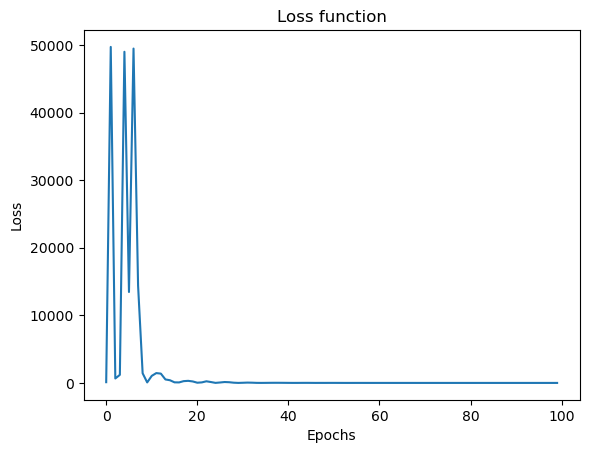

In [84]:
plt.plot(lo)#shows plot of the presented system
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [87]:
err = []
for j in range(len(pred_test)):
    p = pred_test[j]
    t = y_test[j]
    for i in range(len(p)):
        error = abs(p[i].item() - t[i].item())
        err.append(error)
round(s.mean(err),4)

0.184


In [88]:
err2 = []
for j in range(len(pred_train)):
    p2 = pred_train[j]
    t2 = y_train[j]
    for i in range(len(p2)):
        error2 = abs(p2[i].item() - t2[i].item())
        err2.append(error2)
round(s.mean(err2),4)

0.1413


## Only one athlete

In [89]:
df = pd.read_csv(path+ '\df_good_age_wind.csv')
df = df.drop(columns = ['Unnamed: 0'])
df

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,sb,height,Temperature,Humidity,Pressure,Condition,value,country_id,country_comp_id,city_comp_id
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,...,NaN,473.0,35.000000,26.5,1000.810000,Fair,1,163,45,1319
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,...,NaN,61.0,17.141071,NaN,1008.029107,NaN,1,163,163,1467
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,...,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,163,163,3198
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,...,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,163,163,3198
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,...,NaN,164.0,18.555556,NaN,1005.761693,NaN,1,163,46,3031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,...,NaN,438.0,11.400000,NaN,1018.700000,NaN,1,52,52,1023
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,...,NaN,438.0,17.800000,83.0,1021.130000,Light Rain,1,52,52,800
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,...,10.71,438.0,17.800000,83.0,1021.130000,Light Rain,1,52,52,800
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,...,NaN,438.0,21.100000,80.5,1015.880000,Mostly Cloudy,1,52,52,1351


In [90]:
country_id_list = sorted(df['country_id'].unique())
all_country = []
if df['country_id'].max() > df['country_comp_id'].max():
    maxi = df['country_id'].max()
else:
    maxi = df['country_comp_id'].max()
for i in range(maxi+1):
    if i in country_id_list:
        all_country.append(df['country'][df['country_id']== i].reset_index().loc[0]['country'])
    else:
        all_country.append(df['country_competition'][df['country_comp_id']== i].reset_index().loc[0]['country_competition'])

In [91]:
maxi2 = df['city_comp_id'].max()
all_city = []    
for i in range(maxi2+1):
    all_city.append(df['city_competition'][df['city_comp_id']== i].reset_index().loc[0]['city_competition'])

In [94]:
dict_country_new = np.load(path + '\dict_country_new.npy', allow_pickle=True)
dict_country_new = dict(enumerate(dict_country_new.flatten()))[0]

In [123]:
#gui enabling the user to provide the competitor's details and the competition venue
def enter_data():
    global nationality, name, country, city, comp_date
    
    nationality = nationality_combobox.get()
    name = name_combobox.get()
    country = country_combobox.get()
    city = city_combobox.get()
    comp_date = date_box.get()
    
    print(name, 'from', nationality, 'runs', comp_date, 'in', country, 'in', city)

def update_options(event):
    prefix_nat = nationality_combobox.get().lower()
    filtered_nat = [x for x in sorted(df['country'].unique()) if x.lower().startswith(prefix_nat)]
    nationality_combobox['values'] = filtered_nat
    
    selected_nationality = nationality_combobox.get()
    prefix = name_combobox.get().lower()
    filtered_name = [x for x in sorted(df[df['country'] == selected_nationality]['name'].unique()) 
                     if prefix in x.lower()]
    name_combobox['values'] = filtered_name
    
    prefix_cou = country_combobox.get().lower()
    filtered_cou = [x for x in sorted(df['country_competition'].unique()) if x.lower().startswith(prefix_cou)]
    country_combobox['values'] = filtered_cou
    
    selected_country = country_combobox.get()
    prefix_city = city_combobox.get().lower()
    filtered_city = [x for x in sorted(df[df['country_competition'] == selected_country]['city_competition'].unique()) 
                     if x.lower().startswith(prefix_city)]
    city_combobox['values'] = filtered_city
    
window = tkinter.Tk()
window.title("Athlete Information")

frame = tkinter.Frame(window)
frame.pack()

# Saving User Info
user_info_frame = tkinter.LabelFrame(frame)
user_info_frame.grid(row=0, column=0, padx=20, pady=10)

nat_label = tkinter.Label(user_info_frame, text="Narodowość")
nationality_combobox = ttk.Combobox(user_info_frame, values=sorted(list(df['country'].unique())))
nat_label.grid(row=0, column=0)
nationality_combobox.grid(row=1, column=0)
nationality_combobox.bind("<KeyRelease>", update_options)  # Włącz filtrowanie na żywo

name_label = tkinter.Label(user_info_frame, text="Imię i nazwisko")
name_combobox = ttk.Combobox(user_info_frame, values=sorted(list(df['name'].unique())))
name_label.grid(row=0, column=1)
name_combobox.grid(row=1, column=1)
name_combobox.bind("<KeyRelease>", update_options)  # Włącz filtrowanie na żywo

nationality_combobox.bind("<<ComboboxSelected>>", update_options)

cou_label = tkinter.Label(user_info_frame, text="Kraj zawodów")
country_combobox = ttk.Combobox(user_info_frame, values=sorted(list(df['country_competition'].unique())))
cou_label.grid(row=0, column=2)
country_combobox.grid(row=1, column=2)
country_combobox.bind("<KeyRelease>", update_options)  # Włącz filtrowanie na żywo

city_label = tkinter.Label(user_info_frame, text="Miasto zawodów")
city_combobox = ttk.Combobox(user_info_frame, values=sorted(list(df['city_competition'].unique())))
city_label.grid(row=2, column=0)
city_combobox.grid(row=3, column=0)
city_combobox.bind("<KeyRelease>", update_options)  # Włącz filtrowanie na żywo

country_combobox.bind("<<ComboboxSelected>>", update_options)

date_label = tkinter.Label(user_info_frame, text="Data zawodów")
date_box = DateEntry(user_info_frame, width= 16, background= "magenta3", foreground= "white",bd=2)
date_label.grid(row=2, column=1)
date_box.grid(row=3, column=1)


# Button
button = tkinter.Button(frame, text="Save data", command=enter_data)
button.grid(row=6, column=0, sticky="news", padx=20, pady=10)

window.mainloop()

Noah LYLES from United States runs 9/16/23 in United States in Eagle Rock


In [124]:
X = torch.tensor(df_ath.iloc[ :-1].values.tolist())
y = torch.tensor(list(df_ath['result']))

part = int(0.9 * len(X))
X_train = X[:part]
y_train = y[:part]

X_test = X[part:]
y_test = y[part:]

X_train = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

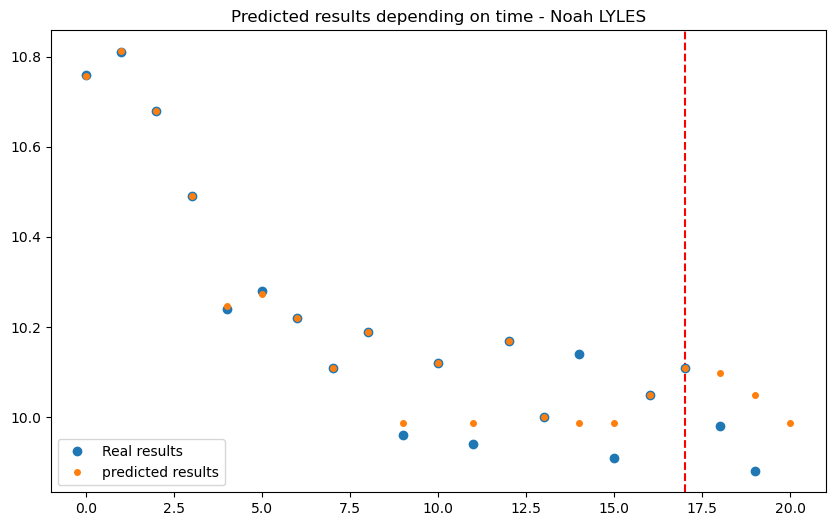

In [125]:
inp = X_train.size()[2]
hidden = 30
output = len(y_train)
learning_rate = 0.001
num_classes = 1
num_layers = 1

model = LSTM1(num_classes, inp, hidden, num_layers, output)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

num_epochs = 100

lo = []

for k in range(1):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        lo.append(loss.item())

        loss.backward()
        optimizer.step()

        model.eval()
        pred_train = model(X_train)
        pred_test = model(X_test)

    plt.figure(figsize=(10,6)) #plotting
    plt.axvline(x=part-1, c='r', linestyle='--') #size of the training set

    dt = torch.cat((pred_train, pred_test), dim=0)
    
    #plt.plot(y, 'o', markersize=6, label='Real results')
    #plt.plot(dt.detach().numpy(), 'o', markersize=4, label='predicted results')
    
    plt.plot(dataY_plot, 'o', markersize=6, label='Real results')
    plt.plot(data_predict, 'o', markersize=4, label='predicted results')

    plt.title('Predicted results depending on time - ' + name)
    plt.legend()
    plt.show()

In [126]:
pre

[[10.098320960998535], [10.049620628356934], [9.98744010925293]]

In [128]:
y_test

tensor([9.9800, 9.8800,    nan])

In [120]:
err = 0
for i in range(len(pred_test)):
    err += abs(pred_test[i].item() - y_test[i].item())
print(round(err/len(pred_test),4))

0.0913


In [121]:
err2 = 0
for i in range(len(pred_train)):
    err2 += abs(pred_train[i].item() - y_train[i].item())
print(round(err2/len(pred_train),4))

0.0262


In [127]:
root = tkinter.Tk()

root.title("Predicting results")
root.geometry("500x450")

im = 'https://media.aws.iaaf.org/athletes/' + str(df_comp['number'][0]) + '.jpg'

# Create a photoimage object of the image in the path
image1 = Image.open(requests.get(im, stream=True).raw)
test = ImageTk.PhotoImage(image1)

label1 = tkinter.Label(image=test, text = 'aaa')
label1.image = test

# Position image
label1.place(x=130, y=5)

text1 = ' From ' + nationality + ' runs ' + comp_date + ' in ' + country + ' in '  + city
text2 = 'Predicted result:'
text3 = round(s.median(pre[-1]), 2)

name_label = tkinter.Label(text=name, font=("The New Roman", 25))
name_label.place(x=120, y=image1.size[1]+20)

text_label = tkinter.Label(text=text1, font=("The New Roman", 15))
text_label.place(x=20, y=image1.size[1]+75)

predict_label = tkinter.Label(text=text2, font=("The New Roman", 15))
predict_label.place(x=140, y=image1.size[1]+110)

result_label = tkinter.Label(text=text3, font=("Verdana", 20), bg = 'green')
result_label.place(x=200, y=image1.size[1]+145)

root.mainloop()

In [129]:
df_comp

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,sb,height,Temperature,Humidity,Pressure,Condition,value,country_id,country_comp_id,city_comp_id
0,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,11.05,2019-02-28,bot,Gaborone,...,NaN,1013.0,21.149879,NaN,1008.717027,NaN,1,5,5,497
1,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.76,2019-12-14,bot,Gaborone,...,11.05,1013.0,21.579365,NaN,1008.400000,NaN,1,5,5,497
2,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.81,2019-12-14,bot,Gaborone,...,10.76,1013.0,21.579365,NaN,1008.400000,NaN,1,5,5,497
3,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.68,2019-12-14,bot,Gaborone,...,10.76,1013.0,21.579365,NaN,1008.400000,NaN,1,5,5,497
4,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.58,2020-02-28,bot,Gaborone,...,NaN,1013.0,21.149879,NaN,1008.717027,NaN,1,5,5,497
5,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.49,2020-03-14,bot,Gaborone,...,10.58,1013.0,20.074561,NaN,971.860000,NaN,1,5,5,497
6,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.39,2021-04-17,bot,Gaborone,...,NaN,1013.0,18.045707,NaN,1016.390000,NaN,1,5,5,497
7,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.24,2021-05-15,bot,Gaborone,...,10.39,1013.0,16.730612,NaN,1020.450000,NaN,1,5,5,497
8,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.28,2021-05-16,bot,Gaborone,...,10.24,1013.0,16.730612,NaN,1020.450000,NaN,1,5,5,497
9,Letsile TEBOGO,Botswana,bot,14883897,2003-06-07,https://www.worldathletics.org/athletes/Botswa...,10.22,2021-08-18,ken,Nairobi,...,10.24,762.0,18.900000,64.0,832.200000,Mostly Cloudy,1,5,12,4184
